In [1]:
from sklearn.model_selection import train_test_split
import numpy.random as nr
nr.seed = 42

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path as op
import itertools
import re
import xarray as xr

%matplotlib inline

/scratch/adomakor412/conda/envs/MyEnv/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
inputPath = '/scratch/adomakor412/all_npy3'
PATH = os.path.expanduser(inputPath)
ncPath = os.path.expanduser('/scratch/adomakor412/april_data_2019')

In [4]:
columns = [
    "time",
    "longitude",
    "latitude",
    #"band",#Necessary?
    "G17_Temp",
    "G17_mean",
    "G17_std",#mean and std outside inner for loop for comp. eff.
    "target_G16_Temp"
]

df = pd.DataFrame({},columns = columns)


In [5]:
print(len(df))

0


In [6]:
def longitude(lonMin, lonMax, col, colSize):
    lon = (col/colSize)* (lonMax - lonMin)
    return lon

def latitude(latMin, latMax, row, rowSize):
    lat = (row/rowSize)* (latMax - latMin)
    return lat

def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [7]:
import logging
logger = logging.getLogger()

In [46]:
extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]

with open('logML', 'a') as log:   
    for (bb,dd) in list(itertools.product([8],[5])):#Let's start with one day
        DD = str(98+dd).zfill(3)
        lookup = f'M6C08_G17_s2019{DD}0000'
        ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
        #ncFiles = mySort(ncFiles)
        npFiles = [f for f in os.listdir( PATH ) if re.search(lookup,f)]
        #ncFiles = mySort(ncFiles)

        for ncf, npf in zip(ncFiles,npFiles):
            try:
                imageBox = np.load(op.join( PATH,npf))
                myFile = xr.open_dataset(op.join(ncPath,ncf))
                planck_fk1 = float(myFile['planck_fk1'].data)
                planck_fk2 = float(myFile['planck_fk2'].data) 
                planck_bc1 = float(myFile['planck_bc1'].data)                       
                planck_bc2 = float(myFile['planck_bc2'].data)

                time = ncf[31:38]
                G17_mean = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                G17_std = Rad2BT(imageBox.std(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

                hh = ncf[34:36]
                mm = ncf[36:38]
                
                print(ncf)
                print(str(ncf), file=log)
                logger.info(str(ncf))

                G16_npy = np.load( op.join(PATH, npf.replace('G16','G17',1)) )
                G16_ncf = xr.open_dataset(op.join( ncPath, ncf.replace('G16','G17',1) ))
                G16_fk1 = float(G16_ncf['planck_fk1'].data)
                G16_fk2 = float(G16_ncf['planck_fk2'].data) 
                G16_bc1 = float(G16_ncf['planck_bc1'].data)                       
                G16_bc2 = float(G16_ncf['planck_bc2'].data)

                target_G16_Temp = Rad2BT(G16_npy, G16_fk1, G16_fk2, G16_bc1, G16_bc2)
                x,y = imageBox.shape[0],imageBox.shape[1]
                for i,j in itertools.product(range(x),range(y)):
                    lon = longitude( extent_pc[0], extent_pc[1], i, x )
                    lat = latitude( extent_pc[2], extent_pc[3], j, y)

                    G17_Temp = Rad2BT(imageBox[i,j], planck_fk1, planck_fk2, planck_bc1, planck_bc2)#unfiltered
                    target_G16_Temp = Rad2BT( G16_npy[i,j], G16_fk1, G16_fk2, G16_bc1, G16_bc2 )
                    
                    row = [time, lon, lat, G17_Temp, G17_mean, G17_std, target_G16_Temp]

                    df = df.append(pd.DataFrame([row],columns=columns),ignore_index=True)
                    
            except ValueError as e:
                logger.exception(e)
                print(e)
                print(e, file=log)
                continue 
    
# df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=columns)
# for column in df.columns:
#     if df[column].dtype == "object":
#         df[column] = df[column].str.strip()
# df = df.dropna()

OR_ABI-L1b-RadF-M6C08_G17_s20191030000339_e20191030009405_c20191030009441.nc


In [54]:
print(len(df))
print(df.head())

406164
      time  longitude  latitude    G17_Temp    G17_mean     G17_std  \
0  1030000        0.0 -0.000000  242.868317  243.715676  202.188943   
1  1030000        0.0 -0.044621  242.919616  243.715676  202.188943   
2  1030000        0.0 -0.089243  242.919616  243.715676  202.188943   
3  1030000        0.0 -0.133864  242.919616  243.715676  202.188943   
4  1030000        0.0 -0.178485  242.919616  243.715676  202.188943   

   target_G16_Temp  
0       242.868317  
1       242.919616  
2       242.919616  
3       242.919616  
4       242.919616  


In [55]:
print(len(df.dropna()))
print(df.dropna().head())

406164
      time  longitude  latitude    G17_Temp    G17_mean     G17_std  \
0  1030000        0.0 -0.000000  242.868317  243.715676  202.188943   
1  1030000        0.0 -0.044621  242.919616  243.715676  202.188943   
2  1030000        0.0 -0.089243  242.919616  243.715676  202.188943   
3  1030000        0.0 -0.133864  242.919616  243.715676  202.188943   
4  1030000        0.0 -0.178485  242.919616  243.715676  202.188943   

   target_G16_Temp  
0       242.868317  
1       242.919616  
2       242.919616  
3       242.919616  
4       242.919616  


In [62]:
columns

['time',
 'longitude',
 'latitude',
 'G17_Temp',
 'G17_mean',
 'G17_std',
 'target_G16_Temp']

In [73]:
dfSample = df.dropna().sample(n=1000)
X = dfSample.drop(["target_G16_Temp"],axis=1).astype('int')
y = dfSample.drop(columns[:-1],axis=1).astype('int')

In [74]:
X.head()

,time,longitude,latitude,G17_Temp,G17_mean,G17_std
226479,1030000,3,-16,246,243,202
160674,1030000,2,-14,245,243,202
6049,1030000,0,-3,242,243,202
328726,1030000,5,-15,241,243,202
202983,1030000,3,-5,246,243,202


In [75]:
y.head()

,target_G16_Temp
226479,246
160674,245
6049,242
328726,241
202983,246


https://erikbern.com/2018/02/15/new-benchmarks-for-approximate-nearest-neighbors.html

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


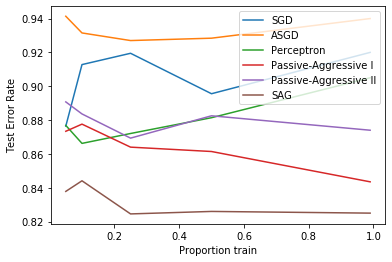

In [76]:
# Get baseline results here with logisic regression and random forest
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
#REGRESSION TREE B/C IF TIME IS IN WINDOW OF ANOMALY IT WILL DO ONE THING OTHERWISE ANOTHER DO ANOTHER THING
#Try KNN apx

# Set up your models here

def model_one():
    pass

def model_two():
    pass

def model_three():
    pass

def model_four():
    pass

def model_five():
    pass

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20

classifiers = [
    ("SGD", SGDClassifier(max_iter=100)),#Gradient Descent
    ("ASGD", SGDClassifier(average=True)),#Adaptive Gradient Descent
    ("Perceptron", Perceptron()),#Linear Classifier
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))#Stochastic Average Gradient
]

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == np.array(y_test)))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

KFold(n_splits=5, random_state=None, shuffle=False)
training Passive-Aggressive I
training SAG


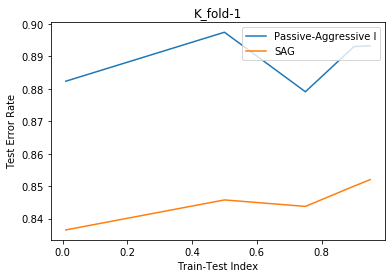

training Passive-Aggressive I
training SAG


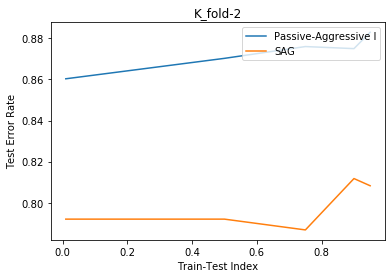

training Passive-Aggressive I
training SAG


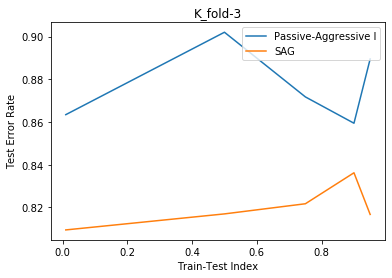

training Passive-Aggressive I
training SAG


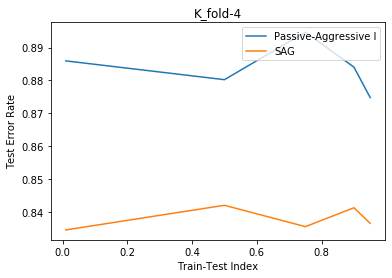

training Passive-Aggressive I
training SAG


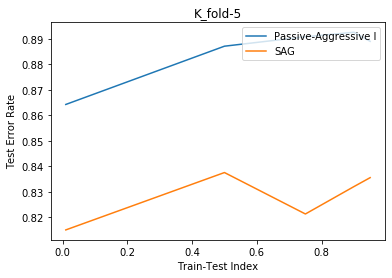

In [104]:
# Part 4 inplement cross validation here
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)
print(kf)

xx = ['K_fold-1','K_fold-2','K_fold-3','K_fold-4','K_fold-5']
rounds = 20

count = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(X)[np.array(train_index)], np.array(X)[np.array(test_index)]
    y_train, y_test = np.array(y)[np.array(train_index)], np.array(y)[np.array(test_index)]
        
    classifiers = [
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))
    ]
    
    for name, clf in classifiers:
        print("training %s" % name)
        
        rng = np.random.RandomState(42)
        yy = []
        for i in heldout:
            yy_ = []
            for r in range(rounds):
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                yy_.append(1 - np.mean(y_pred == np.array(y_test)))
            yy.append(np.mean(yy_))
             
        plt.plot(heldout, yy, label=name)
    plt.title(xx[count])
    count+=1
        

    plt.legend(loc="upper right")
    plt.xlabel("Train-Test Index")
    plt.ylabel("Test Error Rate")
    plt.show()